## Background

We want to be able to load R models using Python and describe, test and evaluate them using the ValidMind framework like we do with Python models. This notebook demonstrates how we can load R models either from an RDS file or by building the model in R directly in the notebook with the `rpy2` package. Either way, we can then use the ValidMind framework to run a TestPlan designed for the model (in this case, a simple ECM model).

In [2]:
# lets import the required libraries
import os
import tempfile

import pandas as pd
import rpy2.robjects as robjects
from IPython.display import display_png
from PIL import Image as PILImage
from rpy2.robjects.packages import importr

# import the R packages
tidyverse = importr("tidyverse")
broom = importr("broom")
graphics = importr("graphics")
grdevices = importr("grDevices")

/Users/jwalz/Library/Caches/pypoetry/virtualenvs/validmind-mI3jzOkk-py3.10/lib/python3.10/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# Load the RDS model we created earlier (in r-ecm-model notebook)
# alternatively, the model could be recreated in rpy2 from scratch
r_model = robjects.r["readRDS"]("r-ecm-model.rds")

In [4]:
# lets run summary on the model
# in pure R, this would be: `summary(model)`
# for this, however we want to get a string representation of the summary
# so we can use it in python
summary = robjects.r["summary"](r_model)
summary_str = str(summary)
print(summary_str)


Call:
lm(formula = dy ~ ., data = x, weights = weights)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.9223 -0.6088  0.0210  0.6822  3.9381 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -0.4160213  0.8236705  -0.505 0.614155    
deltaCorpProfits   0.0119853  0.0020332   5.895 1.97e-08 ***
deltaFedFundsRate -0.1231619  0.1547487  -0.796 0.427210    
deltaUnempRate    -1.4841457  0.4389805  -3.381 0.000896 ***
CorpProfitsLag1    0.0027077  0.0008258   3.279 0.001265 ** 
FedFundsRateLag1   0.0655636  0.0494706   1.325 0.186849    
UnempRateLag1     -0.0532751  0.1040916  -0.512 0.609448    
yLag1             -0.0337028  0.0192679  -1.749 0.082066 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.711 on 170 degrees of freedom
Multiple R-squared:  0.2919,	Adjusted R-squared:  0.2628 
F-statistic: 10.01 on 7 and 170 DF,  p-value: 1.885e-10




In [5]:
# now lets something similar to run tidy, augment, and glance
# in pure R, this would be: `tidy(model)`, `augment(model)`, `glance(model)`
# however, we want to end up with a pandas dataframe containing the data in the Tibble created by these functions
tidy = robjects.r["tidy"](r_model)
tidy_df = pd.DataFrame(robjects.conversion.rpy2py(tidy))

augment = robjects.r["augment"](r_model)
augment_df = pd.DataFrame(robjects.conversion.rpy2py(augment))

glance = robjects.r["glance"](r_model)
glance_df = pd.DataFrame(robjects.conversion.rpy2py(glance))

# lets display the dataframes
display(tidy_df)
display(augment_df)
display(glance_df)

,0,1,2,3,4,5,6,7
0,(Intercept),deltaCorpProfits,deltaFedFundsRate,deltaUnempRate,CorpProfitsLag1,FedFundsRateLag1,UnempRateLag1,yLag1
1,-0.416021,0.011985,-0.123162,-1.484146,0.002708,0.065564,-0.053275,-0.033703
2,0.823671,0.002033,0.154749,0.43898,0.000826,0.049471,0.104092,0.019268
3,-0.505082,5.894868,-0.795883,-3.380892,3.27874,1.325304,-0.51181,-1.74917
4,0.614155,0.0,0.42721,0.000896,0.001265,0.186849,0.609448,0.082066


,0,1,2,3,4,5,6,7,8,9,...,168,169,170,171,172,173,174,175,176,177
0,2,3,4,5,6,7,8,9,10,11,...,170,171,172,173,174,175,176,177,178,179
1,-0.023333,0.0,0.126667,0.04,0.013333,0.063333,-0.05,-0.11,0.046667,-0.066667,...,3.668281,4.628594,3.689168,2.55649,3.484343,1.330312,3.180822,2.360396,-3.238249,0.48375
2,4.012,2.183,4.194,1.068,3.195,6.352,11.655,3.034,1.692,4.836,...,27.453,44.735,-79.877,86.058,49.698,15.633,-122.484,64.793,-58.055,-191.198
3,0.91,-0.723333,-1.21,0.76,0.44,0.403333,1.393333,1.28,2.743333,-0.563333,...,-0.033333,0.003333,-0.013333,0.02,-0.003333,0.01,0.01,0.013333,0.013333,0.023333
4,0.133333,-0.1,-0.166667,-0.066667,-0.133333,-0.2,-0.433333,0.0,-0.133333,-0.033333,...,-0.3,-0.3,-0.266667,-0.433333,-0.133333,-0.4,-0.133333,-0.166667,-0.3,-0.1
5,59.168,63.18,65.363,69.557,70.625,73.82,80.172,91.827,94.861,96.553,...,1658.148,1685.601,1730.336,1650.459,1736.517,1786.215,1801.848,1679.364,1744.157,1686.102
6,4.563333,5.473333,4.75,3.54,4.3,4.74,5.143333,6.536667,7.816667,10.56,...,0.116667,0.083333,0.086667,0.073333,0.093333,0.09,0.1,0.11,0.123333,0.136667
7,5.9,6.033333,5.933333,5.766667,5.7,5.566667,5.366667,4.933333,4.933333,4.8,...,7.533333,7.233333,6.933333,6.666667,6.233333,6.1,5.7,5.566667,5.4,5.1
8,1.136667,1.113333,1.113333,1.24,1.28,1.293333,1.356667,1.306667,1.196667,1.243333,...,68.969531,72.637812,77.266406,80.955574,83.512063,86.996406,88.326719,91.507541,93.867937,90.629688
9,-0.571137,0.018616,0.165415,-0.326461,-0.10769,0.07776,0.417852,-0.166964,-0.069546,0.416952,...,2.133892,2.301005,0.741401,2.646158,1.939253,1.94912,-0.082572,1.779979,0.611129,-1.313894


,0
0,2.919125e-01
1,2.627560e-01
2,1.711475e+00
3,1.001190e+01
4,1.885342e-10
5,7.000000e+00
6,-3.441276e+02
7,7.062553e+02
8,7.348913e+02
9,4.979547e+02


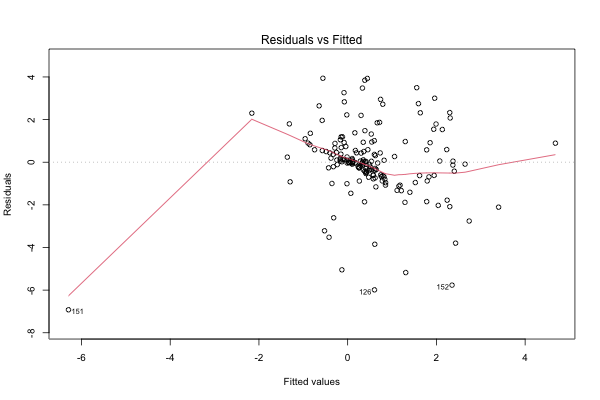

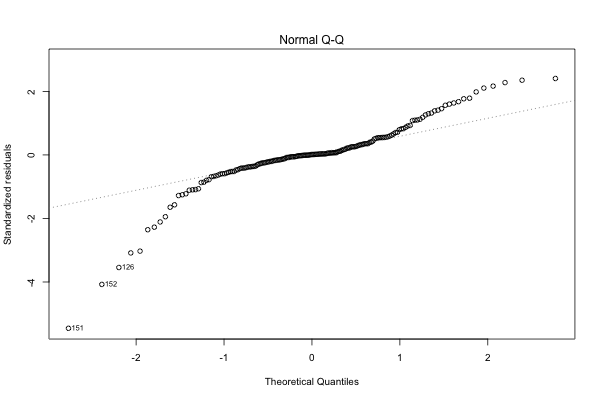

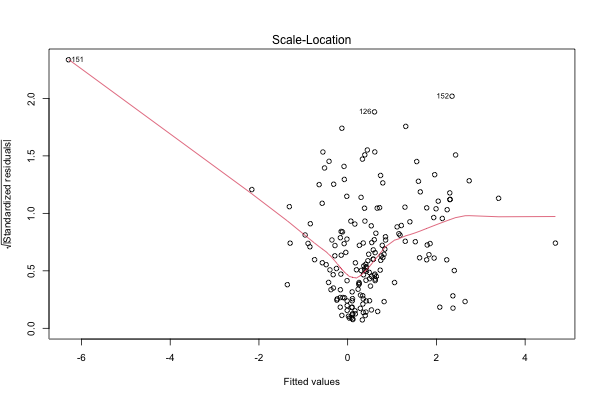

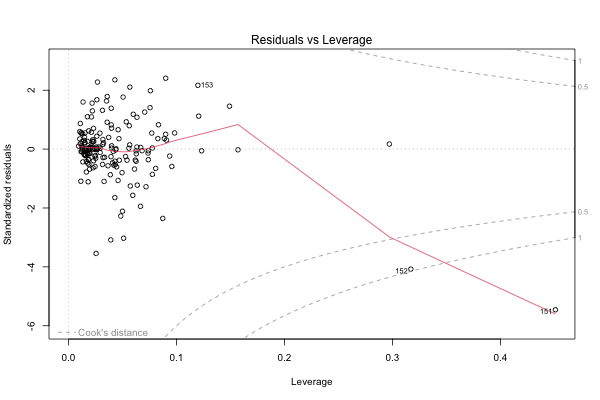

In [6]:
# finally, lets plot the model and somehow get the plots into python
# in pure R, this would be: `plot(model)`
# for this, however we want to get a png image of the plots

# first of all, lets get a temporary file path that we can use to save the image
temp_file = tempfile.NamedTemporaryFile(suffix=".png")

# now lets save the image to the temporary file using grDevices package
grdevices.png(temp_file.name, width=1200, height=800)
graphics.par(mfrow=robjects.IntVector([2, 2]))
robjects.r["plot"](r_model) # creates 4 plots that will be combined into one image
grdevices.dev_off()

# now we split the image into the 4 plots
image = PILImage.open(temp_file.name)
width, height = image.size
plot_width = width / 2
plot_height = height / 2
plots = [
    image.crop((0, 0, plot_width, plot_height)),
    image.crop((plot_width, 0, width, plot_height)),
    image.crop((0, plot_height, plot_width, height)),
    image.crop((plot_width, plot_height, width, height))
]

# display the plots
for plot in plots:
    display_png(plot)

# and finally, lets delete the temporary file
os.remove(temp_file.name)